# PCA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Part1: Data preparation

In [2]:
# Read the data from the file
# Data from https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data?select=Country-data.csv
import requests
def readExcel(excel_id):
  excel_url = 'https://docs.google.com/spreadsheets/d/%s/export?format=xlsx'%excel_id
  response = requests.get(excel_url)
  response.raise_for_status()  # Ensure the request was successful
  with open('sheet.xlsx', 'wb') as file:
      file.write(response.content)
  df = pd.read_excel('sheet.xlsx', nrows=50000)
  return df

dfEURUSD = readExcel("1YxCXl9rjjNVJObw9ZjsgQ6peZGBnbVBXpcYD0RBolJA")
dfEURCHF= readExcel("1f-7jNk7R6X2pz9cJ7VTvDSp8CKQdpDQUqJCM25Schuk")
dfEURJPY= readExcel("1GvDoJCLO0SrbvhuIDh5y-Keo8cCYpxvt7Hrw5ULWOMA")
dfUSDCHF= readExcel("13aPZtPOEYBJ7nA5wuT4JPM2f-xuQNvDKAzJ7tMGBiTM")
dfUSDJPY= readExcel("1t97Tb9A7_cyKP3pYEv4E7kZ1TV0hCvnWFEsFC7eFDDc")

In [3]:
# Check the first few lines to see the column names and type of content
dfEURUSD.head()

,DATE_TIME,HIGH,LOW,OPEN,CLOSE
0,2000.01.03 00:00:00,1.0080,1.0073,1.0073,1.0077
1,2000.01.03 00:15:00,1.0087,1.0076,1.0078,1.0086
2,2000.01.03 00:30:00,1.0089,1.0079,1.0087,1.0079
3,2000.01.03 00:45:00,1.0132,1.0078,1.0078,1.0128
4,2000.01.03 01:00:00,1.0133,1.0120,1.0129,1.0122


In [4]:
# Size of the dataframe
dfEURUSD.shape

(50000, 5)

In [5]:
# Let us check the types of the different columns
dfEURUSD.dtypes

,0
DATE_TIME,object
HIGH,float64
LOW,float64
OPEN,float64
CLOSE,float64


In [6]:
# Let us adapt the dataframe (remove IDs add YEAR and MONTH, and make sure that columns have the right type)
df_all=pd.DataFrame()

df_all["DATETIME"] = pd.to_datetime(dfEURUSD["DATE_TIME"], format='%Y.%m.%d %H:%M:%S')
df_all['YEAR']=df_all.DATETIME.dt.year
df_all['MONTH']=df_all.DATETIME.dt.month

df_all['EURUSD']=dfEURUSD.CLOSE
df_all['EURCHF']=dfEURCHF.CLOSE
df_all['EURJPY']=dfEURJPY.CLOSE
df_all['USDCHF']=dfUSDCHF.CLOSE
df_all['USDJPY']=dfUSDJPY.CLOSE

# quick view of the new dataframe
df_all

,DATETIME,YEAR,MONTH,EURUSD,EURCHF,EURJPY,USDCHF,USDJPY
0,2000-01-03 00:00:00,2000,1,1.0077,1.6048,102.95,1.5922,102.14
1,2000-01-03 00:15:00,2000,1,1.0086,1.6065,103.13,1.5928,102.26
2,2000-01-03 00:30:00,2000,1,1.0079,1.6063,102.96,1.5937,102.15
3,2000-01-03 00:45:00,2000,1,1.0128,1.6060,103.07,1.5857,102.20
4,2000-01-03 01:00:00,2000,1,1.0122,1.6054,103.38,1.5860,102.12
...,...,...,...,...,...,...,...,...
49995,2002-01-07 01:00:00,2002,1,0.8964,1.4790,115.57,1.6551,131.39
49996,2002-01-07 01:15:00,2002,1,0.8964,1.4792,115.44,1.6553,131.33
49997,2002-01-07 01:30:00,2002,1,0.8961,1.4784,115.48,1.6558,131.03
49998,2002-01-07 01:45:00,2002,1,0.8959,1.4783,115.46,1.6551,131.11


## Part 2: Data exploration

In [7]:
# Lets see the summary of the numerical columns
df_all.describe()

,DATETIME,YEAR,MONTH,EURUSD,EURCHF,EURJPY,USDCHF,USDJPY
count,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2001-01-03 06:05:36.420000128,2000.510660,6.474900,0.909737,1.533626,109.608679,1.687949,114.783778
min,2000-01-03 00:00:00,2000.000000,1.000000,0.823200,1.439700,89.610000,1.544300,101.410000
25%,2000-07-04 01:41:15,2000.000000,3.000000,0.880800,1.512500,106.250000,1.643500,107.670000
50%,2001-01-03 22:07:30,2001.000000,6.000000,0.903300,1.528400,109.210000,1.675000,114.740000
75%,2001-07-05 14:18:45,2001.000000,9.000000,0.936500,1.552900,115.020000,1.728900,121.840000
max,2002-01-07 02:00:00,2002.000000,12.000000,1.040800,1.618100,119.700000,1.829300,132.220000
std,NaN,0.512847,3.450404,0.042287,0.038545,5.186936,0.058168,7.539621


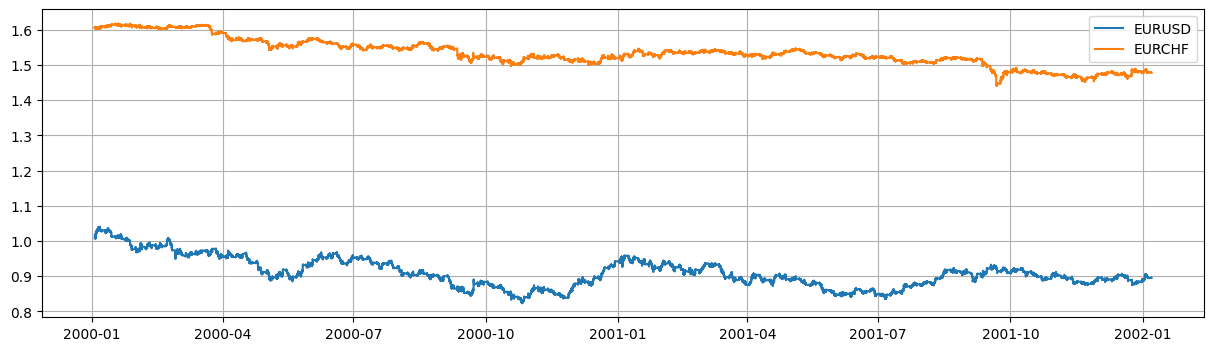

In [8]:
# temporal evolution of EURUSD and EURCHF

fig = plt.figure(2,figsize=(15,4))
plt.plot(df_all.DATETIME, df_all.EURUSD, label= 'EURUSD')
plt.plot(df_all.DATETIME, df_all.EURCHF, label= 'EURCHF')
plt.grid()
plt.legend()
plt.show()

#### We filter those YEARS and MONTHS of interest (important *)

In [9]:
#  Filter data to set the final problem
first_year = 2000
last_year  = 2002

first_month = 1
last_month  = 12

rows_sel = ((df_all.YEAR >= first_year) &  (df_all.YEAR <= last_year)) & ((df_all.MONTH >= first_month) &  (df_all.MONTH <= last_month))
df = df_all.loc[rows_sel].copy()

# finally remove temporal variables (not used in PCA)
df = df.drop(['DATETIME', 'YEAR', 'MONTH'], axis = 1)

print('Dataframe df for analysis using PCA: ')
df

Dataframe df for analysis using PCA: 


,EURUSD,EURCHF,EURJPY,USDCHF,USDJPY
0,1.0077,1.6048,102.95,1.5922,102.14
1,1.0086,1.6065,103.13,1.5928,102.26
2,1.0079,1.6063,102.96,1.5937,102.15
3,1.0128,1.6060,103.07,1.5857,102.20
4,1.0122,1.6054,103.38,1.5860,102.12
...,...,...,...,...,...
49995,0.8964,1.4790,115.57,1.6551,131.39
49996,0.8964,1.4792,115.44,1.6553,131.33
49997,0.8961,1.4784,115.48,1.6558,131.03
49998,0.8959,1.4783,115.46,1.6551,131.11


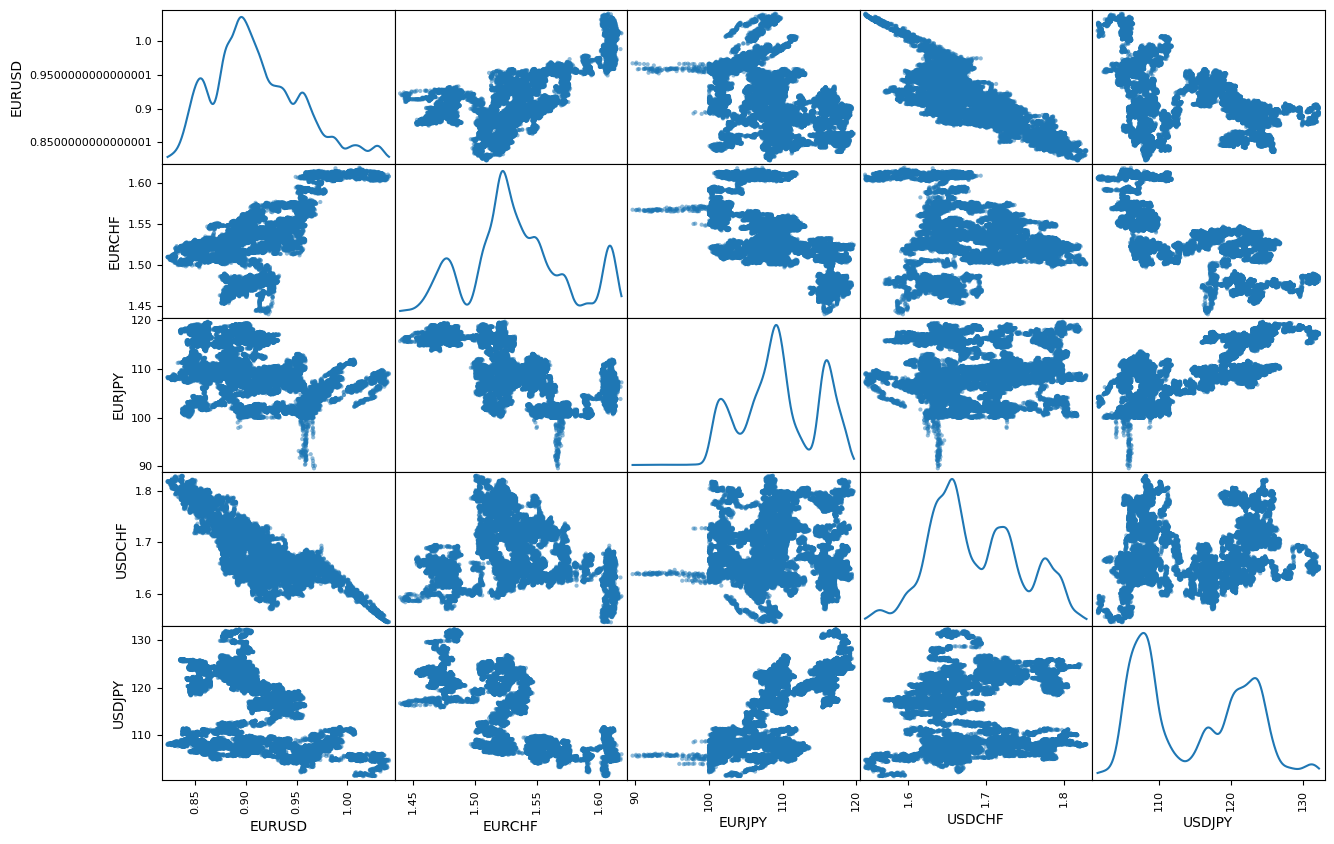

In [10]:
# Matrix scatter plot
fig = pd.plotting.scatter_matrix(df, diagonal='kde', figsize=(15,10));

In [11]:
# Let us explore the correlation matrix
corrMatrix = df.corr(numeric_only=True)
print (corrMatrix)

          EURUSD    EURCHF    EURJPY    USDCHF    USDJPY
EURUSD  1.000000  0.690602 -0.387554 -0.812322 -0.452584
EURCHF  0.690602  1.000000 -0.692126 -0.175893 -0.675036
EURJPY -0.387554 -0.692126  1.000000  0.004917  0.739604
USDCHF -0.812322 -0.175893  0.004917  1.000000  0.095088
USDJPY -0.452584 -0.675036  0.739604  0.095088  1.000000


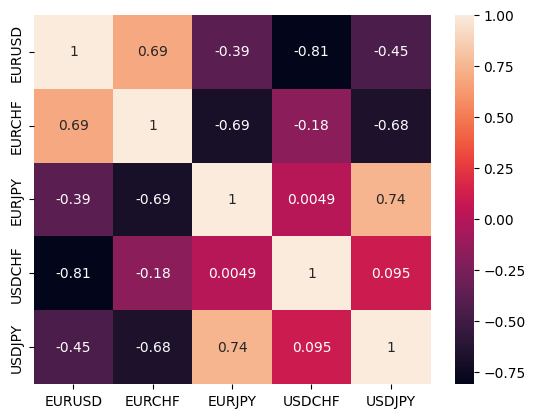

In [12]:
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [13]:
# Mean of each variable
df.mean(axis=0)

,0
EURUSD,0.909737
EURCHF,1.533626
EURJPY,109.608679
USDCHF,1.687949
USDJPY,114.783778


In [14]:
# Standard deviation of each variable
df.std(axis=0)

,0
EURUSD,0.042287
EURCHF,0.038545
EURJPY,5.186936
USDCHF,0.058168
USDJPY,7.539621


## PCA

Principal Component Analysis is one of those tools that do not imply pairs (X,y), but only a collection of {x}.

In [15]:
# Construct the PCA model
X=df
pca_pipe = make_pipeline(StandardScaler(), PCA()) # Scale, then PCA
pca_pipe.fit(X)

model = pca_pipe.named_steps['pca'] # Extract from the pipe the PCA model

In [16]:
# Let us see the principal directions
df_comp = pd.DataFrame(
    data    = model.components_,
    columns = X.columns,
    index   = ['PC%d'%(i+1) for i in range(len(X.columns))]
)

df_comp

,EURUSD,EURCHF,EURJPY,USDCHF,USDJPY
PC1,0.487365,0.513810,-0.452484,-0.270051,-0.469899
PC2,-0.439790,0.151208,-0.401943,0.721623,-0.318470
PC3,-0.179234,-0.704984,-0.211828,-0.328424,-0.564038
PC4,-0.029484,-0.174746,-0.767008,-0.143937,0.599647
PC5,0.732165,-0.430809,-0.022983,0.527023,0.007563


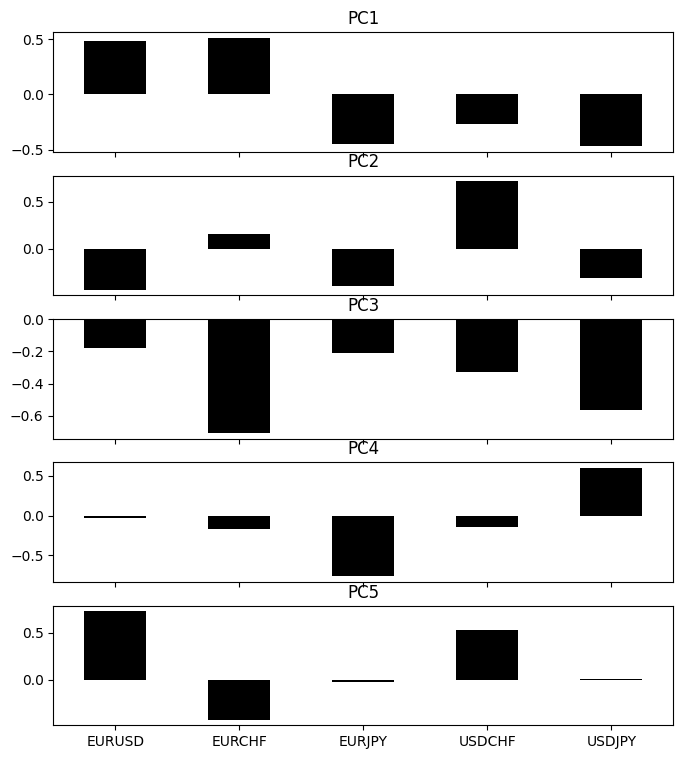

In [17]:
# plot the loads defining each principal component
df_comp.T.plot.bar(figsize=(8, 9), subplots=True, rot = 0, legend = False, color = 'black');

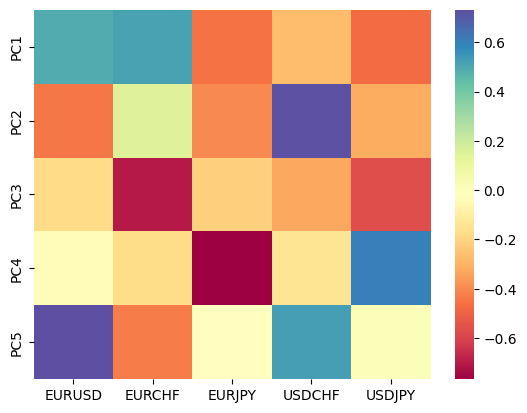

In [18]:
# plot the loads but using a compact form
sns.heatmap(df_comp, cmap='Spectral');

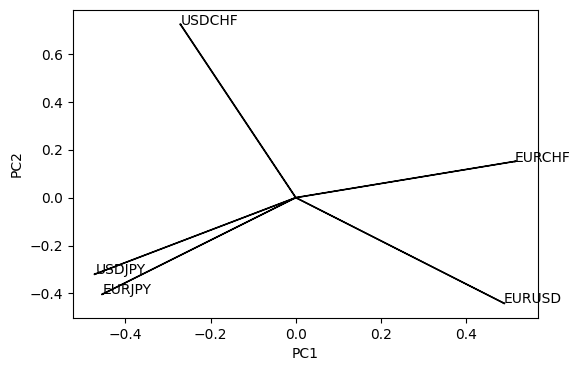

In [19]:
# biplot PC1 and PC2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for i in range(model.components_.shape[1]):
    plt.arrow(0,0,model.components_[0,i],model.components_[1,i])
    plt.text(model.components_[0,i], model.components_[1,i], X.columns[i])
ax.set_xlabel('PC1');
ax.set_ylabel('PC2');
plt.show()

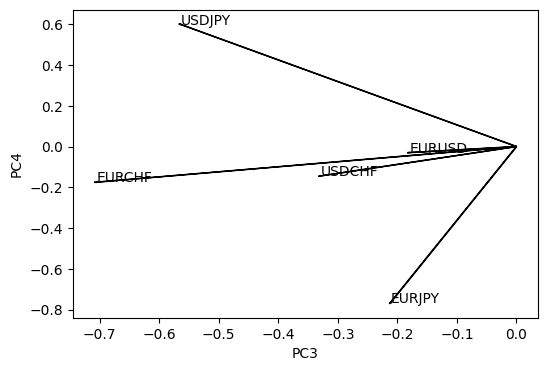

In [20]:
# biplot PC3 and PC4

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for i in range(model.components_.shape[1]):
    plt.arrow(0,0,model.components_[2,i],model.components_[3,i])
    plt.text(model.components_[2,i], model.components_[3,i], X.columns[i])
ax.set_xlabel('PC3');
ax.set_ylabel('PC4');
plt.show()

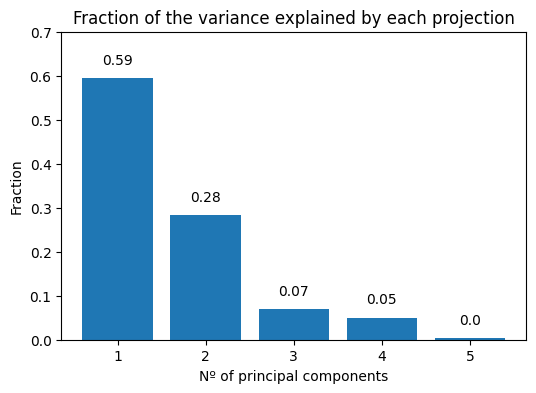

In [21]:
# plot the screeplot (Fraction of the explained variance)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X.columns)) + 1, model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 0.7)
ax.set_title('Fraction of the variance explained by each projection')
ax.set_xlabel('Nº of principal components')
ax.set_ylabel('Fraction');

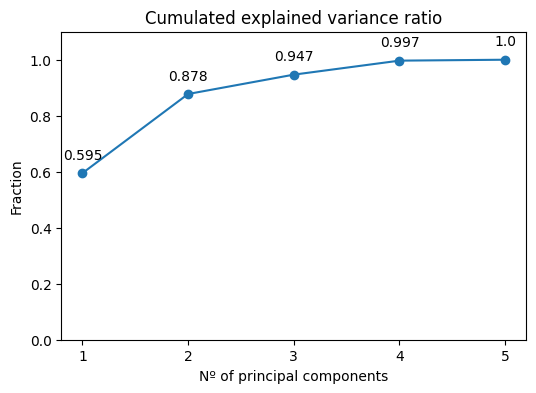

In [22]:
# Cumulated variance
varianceSum = model.explained_variance_ratio_.cumsum()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(X.columns)) + 1,
    varianceSum,
    marker = 'o'
)

for x, y in zip(np.arange(len(X.columns)) + 1, varianceSum):
    label = round(y, 3)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_title('Cumulated explained variance ratio')
ax.set_xlabel('Nº of principal components')
ax.set_ylabel('Fraction');

In [23]:
# Let us now project all countries in the different components
scaler = StandardScaler()
scaler.fit(X)
Xnorm = scaler.transform(X)
Xnew = model.fit_transform(Xnorm)

Text(0, 0.5, 'PC2')

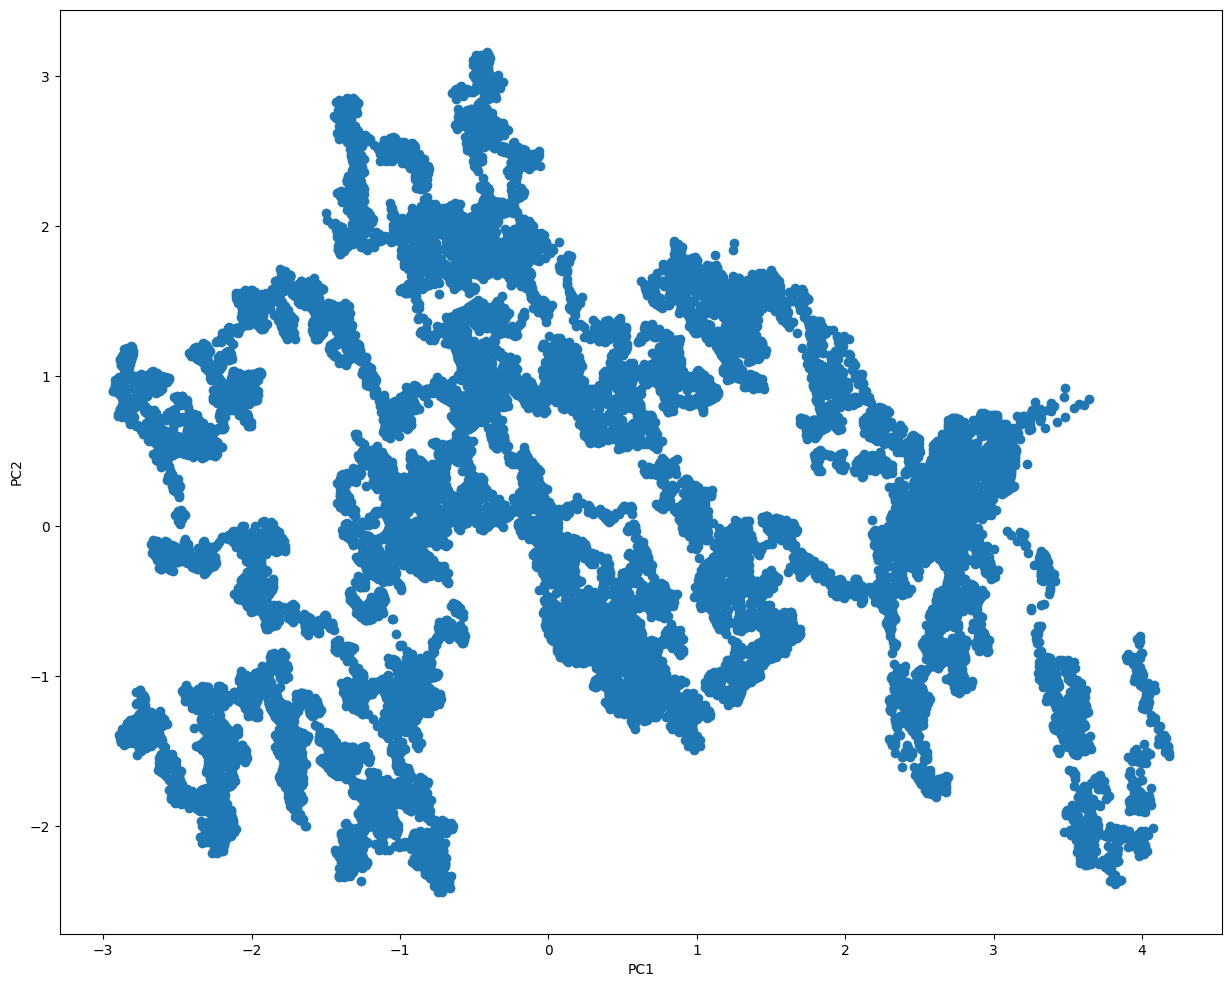

In [24]:
# Let us explore PCA1-PCA2
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
axs.scatter(Xnew[:,0],Xnew[:,1])
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')